<a href="https://colab.research.google.com/github/kiplimock/colab-notebooks/blob/main/semantic_segmentation_with_attention_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Attention Augemented U-Net for Tree Crown Segmentation

Based on the following papers:

1. Jodas, D. S., Velasco, G. D. N., de Lima, R. A., Machado, A. R., & Papa, J. P. (2023). Deep Learning Semantic Segmentation Models for Detecting the Tree Crown Foliage. In VISIGRAPP (4: VISAPP) (pp. 143-150). https://www.scitepress.org/PublishedPapers/2023/116046/116046.pdf

2. Woo, S., Park, J., Lee, JY., Kweon, I.S. (2018). CBAM: Convolutional Block Attention Module. In: Ferrari, V., Hebert, M., Sminchisescu, C., Weiss, Y. (eds) Computer Vision - ECCV 2018. ECCV 2018. Lecture Notes in Computer Science(), vol 11211. Springer, Cham. https://doi.org/10.1007/978-3-030-01234-2_1

### Model Architecture

<p align="center">
  <img src="https://camo.githubusercontent.com/c40a3febddbb349098cf67e237a46f09489a098907772edc30619877f2980039/68747470733a2f2f64726976652e676f6f676c652e636f6d2f75633f6578706f72743d766965772669643d31307532665a6c2d4f4761364a45435f433852493038576933484356574f727057" alt="model architecture">
</p>

### CBAM Module Architecture

<p align="center">
  <img src="https://media.springernature.com/full/springer-static/image/chp%3A10.1007%2F978-3-030-01234-2_1/MediaObjects/474212_1_En_1_Fig1_HTML.gif?as=webp" alt="cbam architecture">
</p>

### Submodules of CBAM

<p align="center">
  <img src="https://media.springernature.com/full/springer-static/image/chp%3A10.1007%2F978-3-030-01234-2_1/MediaObjects/474212_1_En_1_Fig2_HTML.gif?as=webp" alt="cbam submodules">
</p>

### Setup

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf

from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply

### Attention Module

In [2]:
"""
Implementation of CBAM: Convolutional Block Attention Module in the TensorFlow 2.5.
Paper: https://arxiv.org/pdf/1807.06521
Code: https://github.com/nikhilroxtomar/Attention-Mechanism-Implementation/blob/main/TensorFlow/cbam.py
"""

def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

### Depthwise Block

In [3]:
def depthwise_block(input, num_filters):
  d1 = tf.keras.layers.DepthwiseConv2D((3,3), padding='same', depthwise_initializer='he_normal')(input)
  d1 = tf.keras.layers.Conv2D(num_filters, (1, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal')(d1)
  d1 = cbam(d1)
  d1 = tf.keras.layers.BatchNormalization()(d1)
  d1 = tf.keras.layers.Activation('relu')(d1)

  return d1

### Conv2D Block

In [4]:
def conv2d_block(input, num_filters):
  d1 = depthwise_block(input, num_filters)
  d2 = depthwise_block(d1, num_filters)

  shortcut = tf.keras.layers.Conv2D(num_filters, (1, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal')(input)
  shortcut = tf.keras.layers.BatchNormalization()(shortcut)

  out = tf.keras.layers.add([shortcut, d2])

  return out

In [5]:
inputs = Input(shape=(128, 128, 3))
conv2d_block(inputs, 64).shape

TensorShape([None, 128, 128, 64])

### Contraction Path

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

In [7]:

# Building the model
input = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
input = tf.keras.layers.Lambda(lambda x: x / 255.0)(input)

In [8]:
# contraction path
c1 = conv2d_block(input, 64)
p1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c1)

c2 = conv2d_block(p1, 128)
p2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c2)

c3 = conv2d_block(p2, 256)
p3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c3)

c4 = conv2d_block(p3, 512)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c4)

b5 = conv2d_block(p4, 1024)
d5 = tf.keras.layers.Dropout(0.3)(b5)

<p align="center">
  <img src="https://camo.githubusercontent.com/c40a3febddbb349098cf67e237a46f09489a098907772edc30619877f2980039/68747470733a2f2f64726976652e676f6f676c652e636f6d2f75633f6578706f72743d766965772669643d31307532665a6c2d4f4761364a45435f433852493038576933484356574f727057" alt="model architecture">
</p>

In [9]:
# expansion path
u6 = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(b5)
u6 = tf.keras.layers.concatenate([u6, c4])
# u6 shape = (None, 28, 28, 1024)

u7 = depthwise_block(u6, 512)
u7 = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u7)
u7 = tf.keras.layers.concatenate([u7, c3])
# u7 shape = (None, 56, 56, 512)

u8 = depthwise_block(u7, 256)
u8 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u8)
u8 = tf.keras.layers.concatenate([u8, c2])
# u7 shape = (None, 112, 112, 256)

u9 = depthwise_block(u8, 128)
u9 = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u9)
u9 = tf.keras.layers.concatenate([u9, c1])
# u9 shape = (None, 224, 224, 128)

u10 = depthwise_block(u9, 64)
output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(u10)

### Compiling the Model

In [10]:
model = tf.keras.Model(inputs=[input], outputs=[output])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 depthwise_conv2d_2 (Depthw  (None, 224, 224, 3)          30        ['input_3[0][0]']             
 iseConv2D)                                                                                       
                                                                                                  
 conv2d_5 (Conv2D)           (None, 224, 224, 64)         256       ['depthwise_conv2d_2[1][0]']  
                                                                                                  
 global_average_pooling2d_2  (None, 64)                   0         ['conv2d_5[1][0]']        

### Checkpoints and Callbacks

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('crown_seg_model.h5', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

### Preparing the Data

In [12]:
# download the dataset
!git clone https://github.com/recogna-lab/datasets.git
!cp -r datasets/TreeCrown .
!rm -rf datasets/

Cloning into 'datasets'...
remote: Enumerating objects: 7901, done.
remote: Counting objects: 100% (2368/2368), done.
remote: Compressing objects: 100% (2366/2366), done.
remote: Total 7901 (delta 2), reused 2364 (delta 1), pack-reused 5533
Receiving objects: 100% (7901/7901), 1.50 GiB | 39.50 MiB/s, done.
Resolving deltas: 100% (1462/1462), done.
Updating files: 100% (7778/7778), done.
Encountered 1 file(s) that should have been pointers, but weren't:
	TreeSpecies/labels.txt


In [13]:
def prepare_dataset(images_dir, masks_dir):

  train_image_paths = sorted(glob(images_dir + '/*.jpg'))
  train_mask_paths = sorted(glob(masks_dir + '/*.jpg'))

  X_train = np.zeros((len(train_image_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
  Y_train = np.zeros((len(train_image_paths), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

  n = 0
  for image_path, mask_path in tqdm(zip(train_image_paths, train_mask_paths), position=0, leave=True, total=len(train_image_paths)):
    image = imread(image_path)
    mask = imread(mask_path, as_gray=True)
    mask = np.expand_dims(mask, axis=-1)

    X_train[n] = image
    Y_train[n] = mask

    n += 1

  return X_train, Y_train

In [14]:
TRAIN_IMAGES_DIR = "/content/TreeCrown/training/images"
TRAIN_MASKS_DIR = "/content/TreeCrown/training/masks"

X_train, Y_train = prepare_dataset(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR)

100%|██████████| 821/821 [00:02<00:00, 357.07it/s]


In [15]:
VALID_IMAGES_DIR = "/content/TreeCrown/valid/images"
VALID_MASKS_DIR = "/content/TreeCrown/valid/masks"

X_valid, Y_valid = prepare_dataset(VALID_IMAGES_DIR, VALID_MASKS_DIR)

100%|██████████| 176/176 [00:00<00:00, 357.50it/s]


In [16]:
TEST_IMAGES_DIR = "/content/TreeCrown/test/images"
TEST_MASKS_DIR = "/content/TreeCrown/test/masks"

X_test, Y_test = prepare_dataset(TEST_IMAGES_DIR, TEST_MASKS_DIR)

100%|██████████| 176/176 [00:00<00:00, 351.20it/s]


### Training the Model

In [17]:
results = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=100, callbacks=callbacks)

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.7164
Epoch 1: val_loss improved from inf to 0.67004, saving model to crown_seg_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 110s 1s/step - loss: 0.5536 - accuracy: 0.7164 - val_loss: 0.6700 - val_accuracy: 0.6416
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.7767
Epoch 2: val_loss improved from 0.67004 to 0.66783, saving model to crown_seg_model.h5
52/52 [==============================] - 51s 976ms/step - loss: 0.4545 - accuracy: 0.7767 - val_loss: 0.6678 - val_accuracy: 0.7003
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.7870
Epoch 3: val_loss improved from 0.66783 to 0.66261, saving model to crown_seg_model.h5
52/52 [==============================] - 50s 968ms/step - loss: 0.4317 - accuracy: 0.7870 - val_loss: 0.6626 - val_accuracy: 0.7265
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.7920
Epoch 4: val_loss improved from 0.66261 to 0.65411, saving model to crown_seg_model.h5
52/52 [==============================] - 48s 916ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 51s 988ms/step - loss: 0.3752 - accuracy: 0.8065 - val_loss: 0.3833 - val_accuracy: 0.8035
Epoch 16/100
52/52 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8079
Epoch 16: val_loss did not improve from 0.38332
52/52 [==============================] - 49s 950ms/step - loss: 0.3714 - accuracy: 0.8079 - val_loss: 0.3873 - val_accuracy: 0.8016
Epoch 17/100
52/52 [==============================] - ETA: 0s - loss: 0.3701 - accuracy: 0.8079
Epoch 17: val_loss improved from 0.38332 to 0.38298, saving model to crown_seg_model.h5
52/52 [==============================] - 48s 921ms/step - loss: 0.3701 - accuracy: 0.8079 - val_loss: 0.3830 - val_accuracy: 0.8024
Epoch 18/100
52/52 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.8076
Epoch 18: val_loss improved from 0.38298 to 0.38204, saving model to crown_seg_model.h5
52/52 [==============================] - 48s 915ms/step - loss: 0.3704 - accuracy: 0.8076 - 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
model.save('/content/drive/MyDrive/dsail/final_model.keras')

In [31]:
test_im = imread('/content/TreeCrown/test/images/2.jpg')
test_im = np.expand_dims(test_im, axis=0)
res = model.predict(test_im)

1/1 [==============================] - 0s 31ms/step


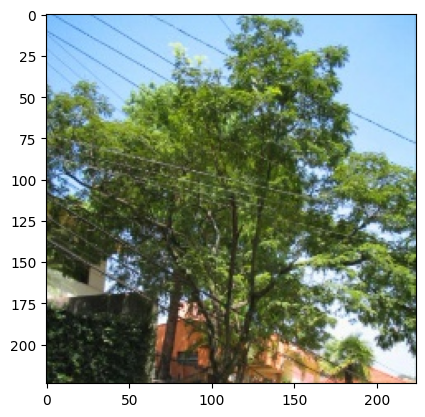

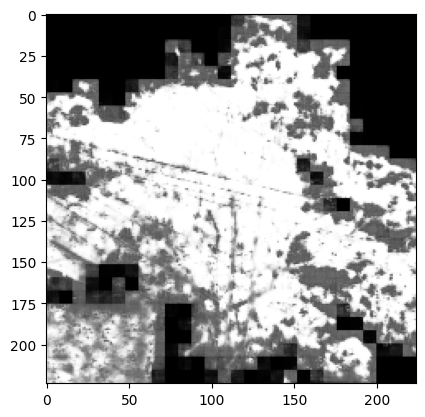

In [32]:
plt.imshow(test_im[0])
plt.show()
plt.imshow(res[0], 'gray')